## Import library

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
%matplotlib inline
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
from time import time
import scipy.fftpack # For FFT2 

## Function Definition

In [2]:
def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def readimage():
    folder = 'image-cancer/'
    list_images = os.listdir(folder)
    list_img = []
    for i in list_images:
        path = folder+i
        print(path)
        img = cv2.imread(path)
        rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))
        list_img.append(rgb_img)
        
    return list_img

def bwarea(img):
    row = img.shape[0]
    col = img.shape[1]
    total = 0.0
    for r in range(row-1):
        for c in range(col-1):
            sub_total = img[r:r+2, c:c+2].mean()
            if sub_total == 255:
                total += 1
            elif sub_total == (255.0/3.0):
                total += (7.0/8.0)
            elif sub_total == (255.0/4.0):
                total += 0.25
            elif sub_total == 0:
                total += 0
            else:
                r1c1 = img[r,c]
                r1c2 = img[r,c+1]
                r2c1 = img[r+1,c]
                r2c2 = img[r+1,c+1]
                
                if (((r1c1 == r2c2) & (r1c2 == r2c1)) & (r1c1 != r2c1)):
                    total += 0.75
                else:
                    total += 0.5
    return total
            
def imclearborder(imgBW, radius):

    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy      

def imfill(im_th):
    
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_out

In [3]:
list_img = readimage()

n_data = len(list_img)

image-cancer/1.png
image-cancer/12.png
image-cancer/13.png
image-cancer/14.png
image-cancer/15.png
image-cancer/17.png
image-cancer/18.png
image-cancer/2.png
image-cancer/31.png
image-cancer/32.png
image-cancer/34.png
image-cancer/35.png
image-cancer/44.png
image-cancer/48.png
image-cancer/5.png
image-cancer/51.png
image-cancer/52.png
image-cancer/53.png
image-cancer/54.png
image-cancer/55.png
image-cancer/56.png
image-cancer/61.png
image-cancer/8.png


## Process

Image 1
Fuzzy time for cluster 2
0.2536814212799072 seconds
Bwarea : 861.0

Fuzzy time for cluster 3
0.43418121337890625 seconds
Bwarea : 750.25

Fuzzy time for cluster 6
2.104552984237671 seconds
Bwarea : 331.0


Image 2
Fuzzy time for cluster 2
0.14739370346069336 seconds
Bwarea : 6723.0

Fuzzy time for cluster 3
0.7199404239654541 seconds
Bwarea : 6226.75

Fuzzy time for cluster 6
2.4775874614715576 seconds
Bwarea : 3982.75


Image 3
Fuzzy time for cluster 2
0.17344188690185547 seconds
Bwarea : 10217.25

Fuzzy time for cluster 3
0.43212223052978516 seconds
Bwarea : 9816.0

Fuzzy time for cluster 6
1.9541809558868408 seconds
Bwarea : 7220.0


Image 4
Fuzzy time for cluster 2
0.14638924598693848 seconds
Bwarea : 18853.5

Fuzzy time for cluster 3
0.3700101375579834 seconds
Bwarea : 17889.5

Fuzzy time for cluster 6
2.6420397758483887 seconds
Bwarea : 15039.0


Image 5
Fuzzy time for cluster 2
0.24665570259094238 seconds
Bwarea : 1375.5

Fuzzy time for cluster 3
0.27573418617248535 seco

C:\Users\Ariff\AppData\Local\conda\conda\envs\image_processing\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Bwarea : 13648.0

Fuzzy time for cluster 3
0.6968424320220947 seconds
Bwarea : 11078.75

Fuzzy time for cluster 6
1.579230546951294 seconds
Bwarea : 7571.75


Image 22
Fuzzy time for cluster 2
0.180511474609375 seconds
Bwarea : 1078.5

Fuzzy time for cluster 3
0.44119977951049805 seconds
Bwarea : 968.75

Fuzzy time for cluster 6
2.1707451343536377 seconds
Bwarea : 156.75


Image 23
Fuzzy time for cluster 2
0.1393721103668213 seconds
Bwarea : 10495.25

Fuzzy time for cluster 3
0.30182933807373047 seconds
Bwarea : 9839.75

Fuzzy time for cluster 6
2.8124780654907227 seconds
Bwarea : 7429.75




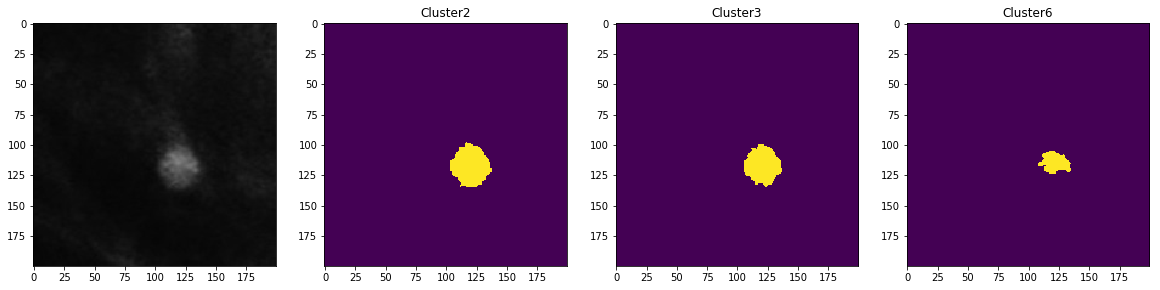

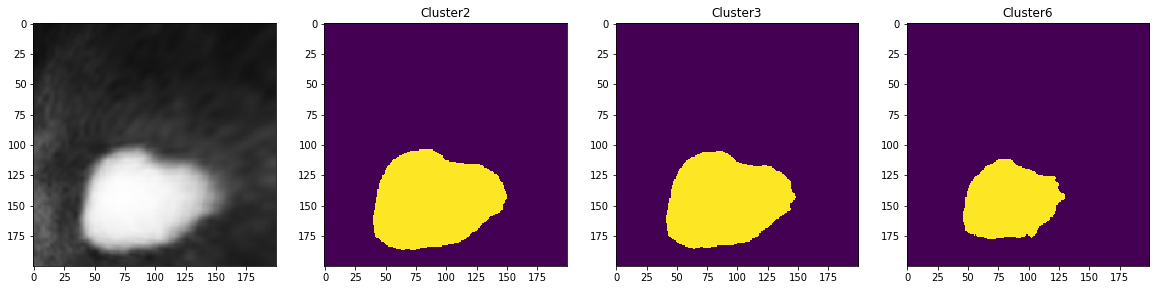

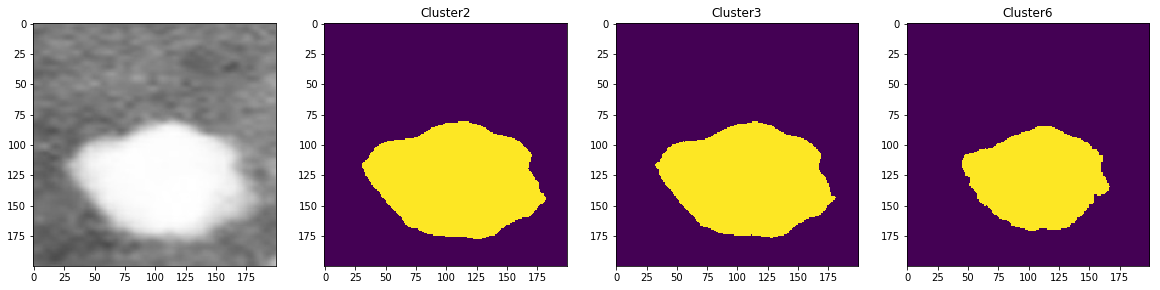

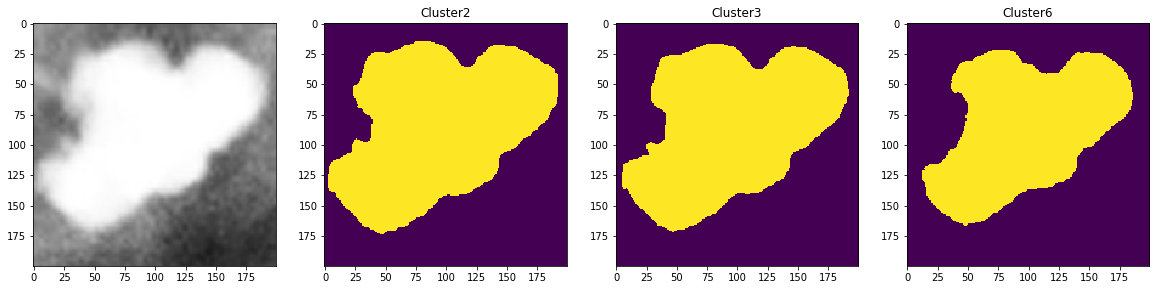

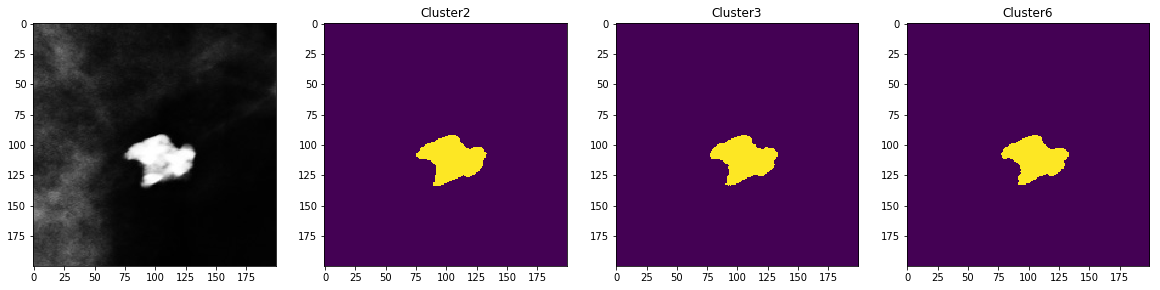

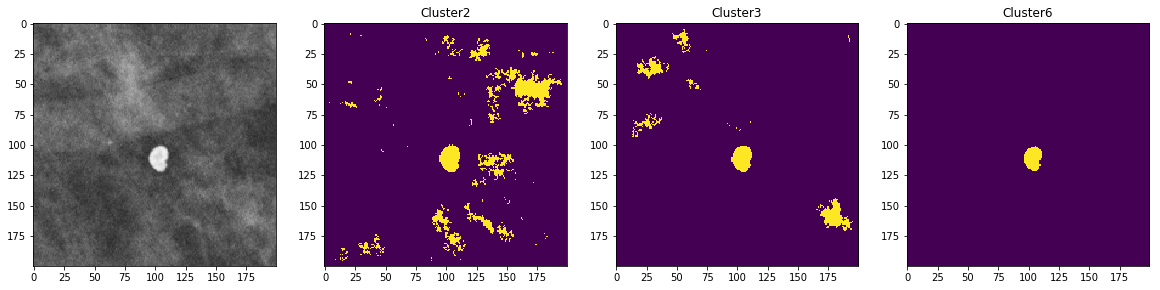

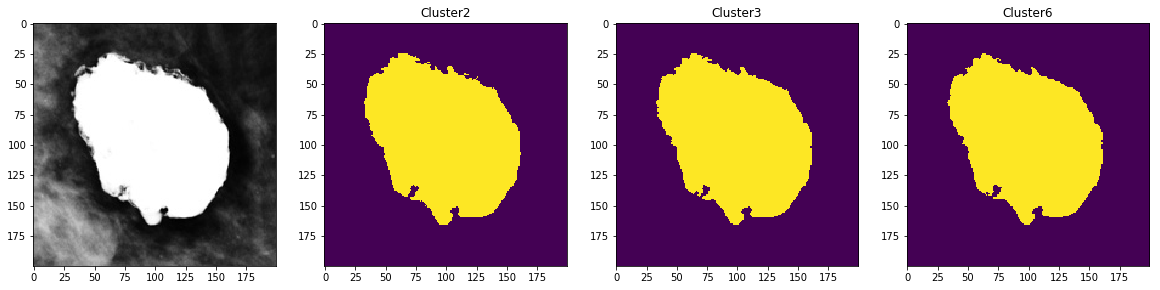

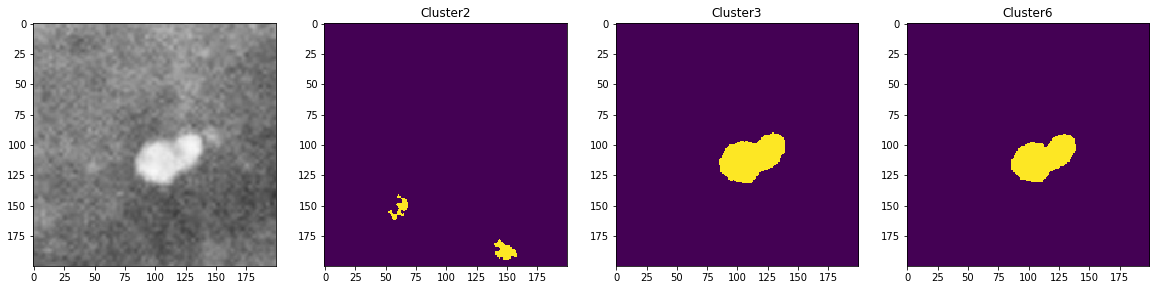

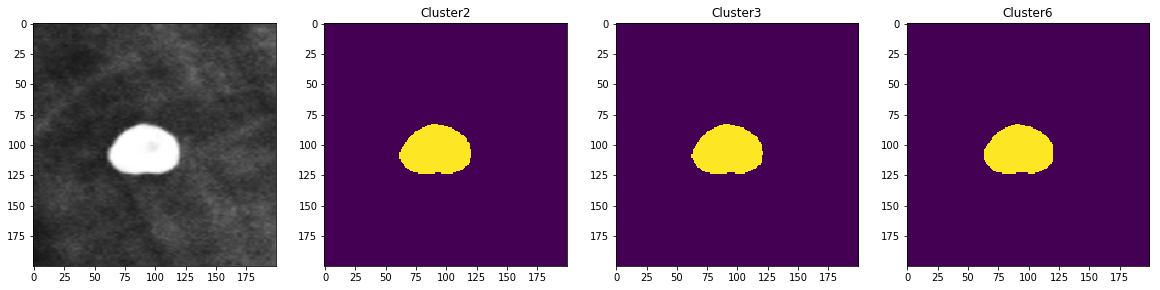

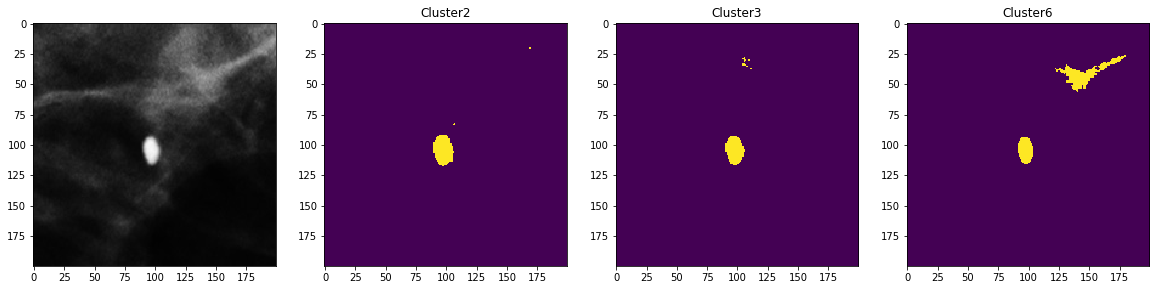

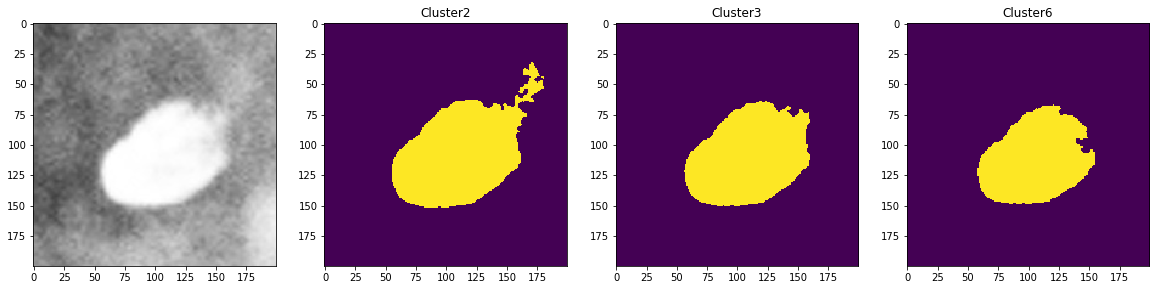

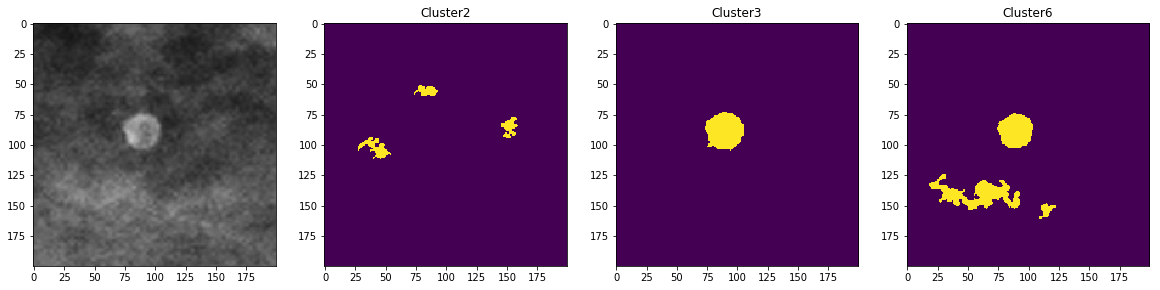

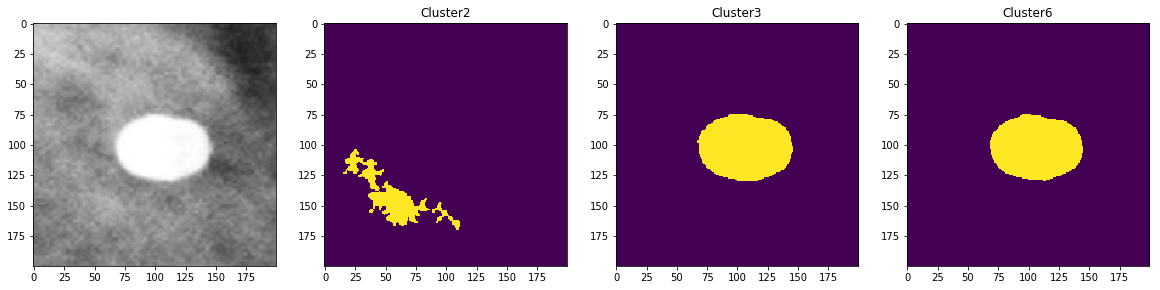

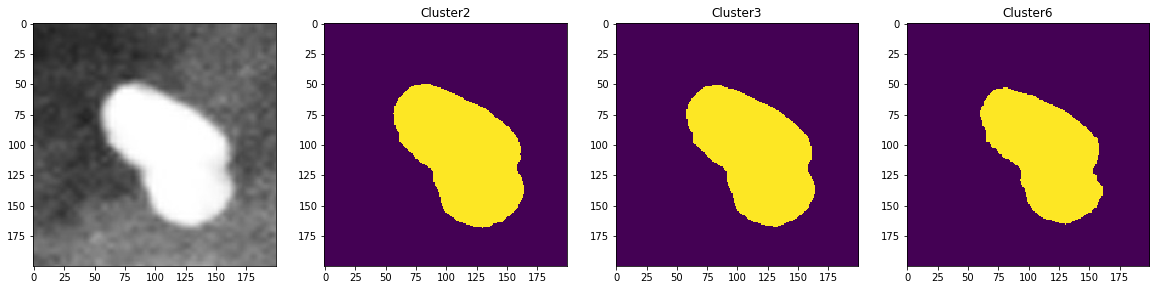

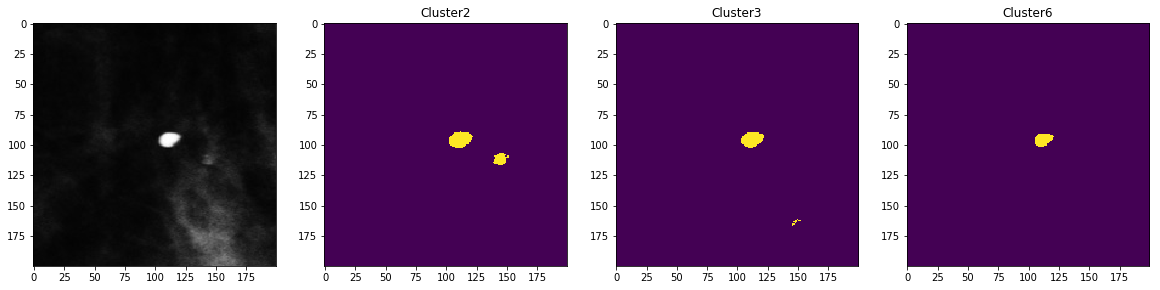

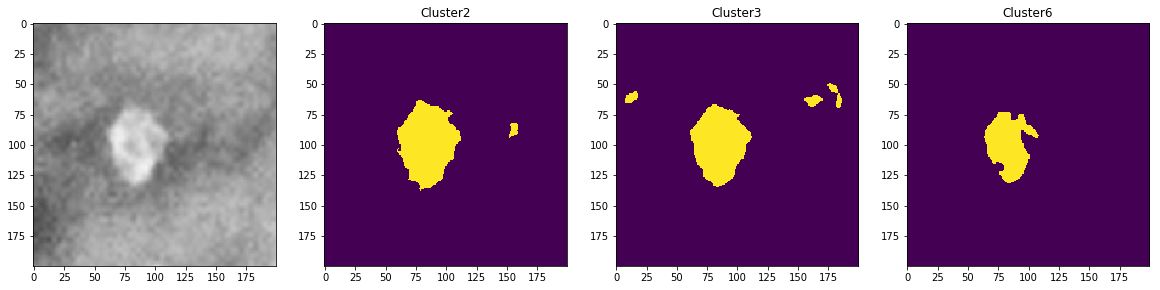

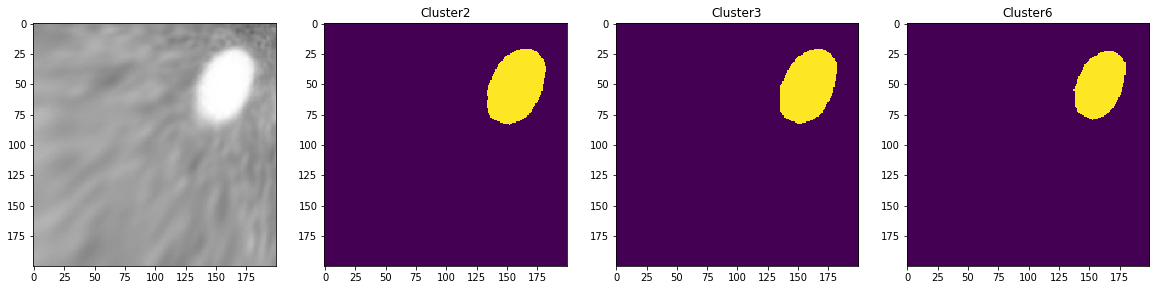

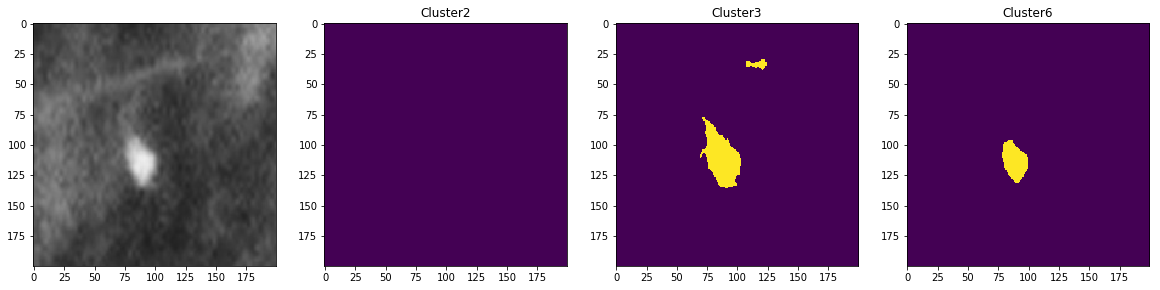

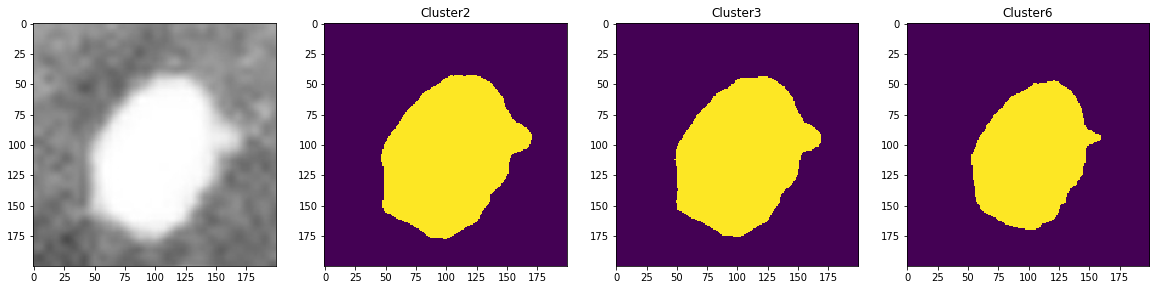

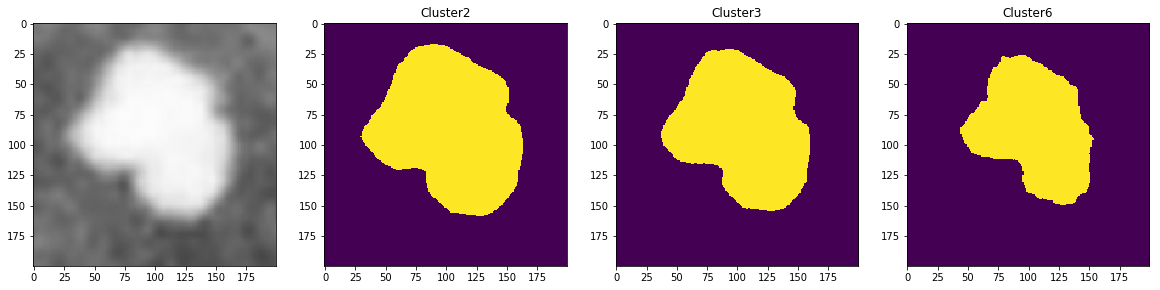

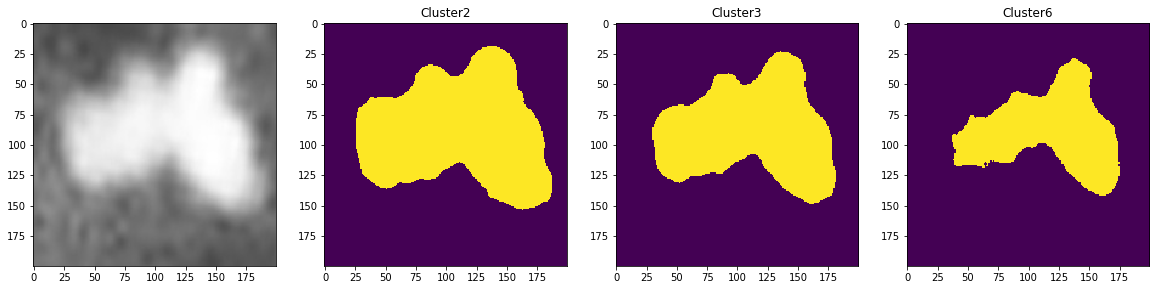

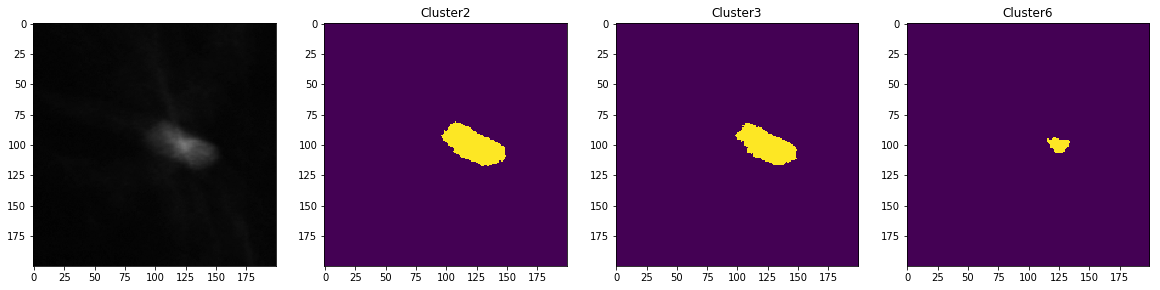

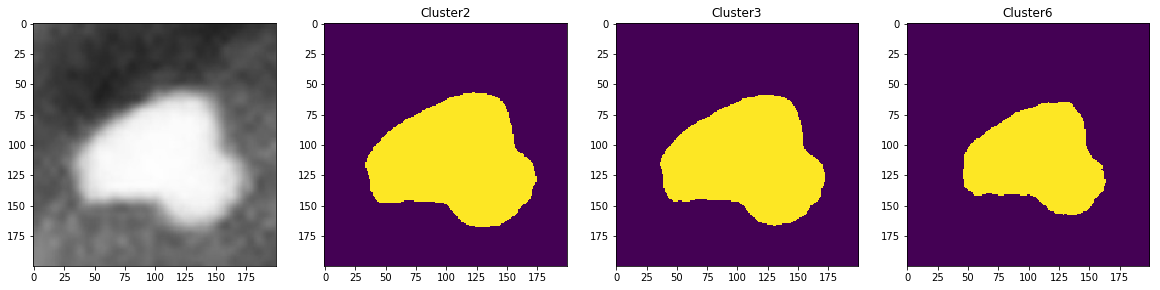

In [5]:
clusters = [2,3,6]

# looping every images
for index,rgb_img in enumerate(list_img):
    img = np.reshape(rgb_img, (200,200,3)).astype(np.uint8)
    shape = np.shape(img)
    
    
    # initialize graph
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img)
    # looping every cluster     
    print('Image '+str(index+1))
    for i,cluster in enumerate(clusters):
            
        # Fuzzy C Means
        new_time = time()
        
        # error = 0.005
        # maximum iteration = 1000
        # cluster = 2,3,6,8
        
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        rgb_img.T, cluster, 2, error=0.005, maxiter=1000, init=None,seed=42)

        new_img = change_color_fuzzycmeans(u,cntr)
        
        fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)
        
        ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)
        
        print('Fuzzy time for cluster',cluster)
        print(time() - new_time,'seconds')
        
        Iopen = bwareaopen(seg_img[:,:,1], 50)
        Iclear = imclearborder(Iopen, 2)
        Imfill = imfill(Iclear)
        
        print('Bwarea : '+str(bwarea(Imfill)))
        print()

        plt.subplot(1,4,i+2)
        plt.imshow(Imfill)
        name = 'Cluster'+str(cluster)
        plt.title(name)

    name = 'segmented'+str(index)+'.png'
    plt.savefig(name)
    print()
    